# Dynamic Search Space Analysis

## Imports

In [2]:
# for colab run
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/projeto/automl-dynamic-search-space/analysis/dynamic-search-space/")

Mounted at /content/drive


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
import os
PATH = "experiments-analysis/"
if not os.path.exists(PATH):
    os.makedirs(PATH)

## Ranking Over Time

### Proposed vs Baseline vs Variations

In [5]:
rs = pd.read_csv("experiments-analysis/RS_over_time_60_36060.csv")
rs_mtl_99 = pd.read_csv("experiments-analysis/RS-mtl-99_over_time_60_36060.csv")
rs_mtl_95 = pd.read_csv("experiments-analysis/RS-mtl-95_over_time_60_36060.csv")
rs_mtl_90 = pd.read_csv("experiments-analysis/RS-mtl-90_over_time_60_36060.csv")
rs_mtl_85 = pd.read_csv("experiments-analysis/RS-mtl-85_over_time_60_36060.csv")
rs_mtl_80 = pd.read_csv("experiments-analysis/RS-mtl-80_over_time_60_36060.csv")
rs_mtl_75 = pd.read_csv("experiments-analysis/RS-mtl-75_over_time_60_36060.csv")

In [6]:
exp_1 = pd.concat([
rs,
rs_mtl_99,
rs_mtl_95,
rs_mtl_90,
rs_mtl_85,
rs_mtl_80,
rs_mtl_75,
])

exp_1["rank"] = exp_1.groupby(["seed", "dataset", "time"])["performance"].rank(ascending=False)

In [7]:
def plot_rank(df, hue_order, end=None, ax=None, legend=False):
  if not ax:
    fig, ax = plt.subplots(figsize=(8, 4))
  aux_ = df
  if end is not None:
    aux_ = aux_.query(f"time <= {end}")
  g = sns.lineplot(
      data=aux_,
      x="time",
      y="rank",
      hue="method",
      ax=ax,
      hue_order=hue_order,
      legend=legend,
      markers=True,
      markevery=0.2,
      style="method",
      dashes=False,
  )
  ax.set(xlabel='time (s)', ylabel='Average Rank')
  if legend:
    sns.move_legend(g, loc="lower center", ncols=len(hue_order), title=None, bbox_to_anchor=(0.5, 1))


def mult_rank_plot(df, hue_order, ends):
  fig, axs = plt.subplots(figsize=(10, 16), nrows=4)
  # fig, axs = plt.subplots(ncols=3)
  df = df[df["method"].isin(hue_order)]
  for end, i in zip(ends, range(len(ends))):
    if 0 == i:
      plot_rank(df, hue_order, end=end, ax=axs[i], legend=True)
    else:
      plot_rank(df, hue_order, end=end, ax=axs[i], legend=False)

  plt.tight_layout()
  fig.savefig("experiments-analysis/ranking_"+"_".join(hue_order)+".pdf")

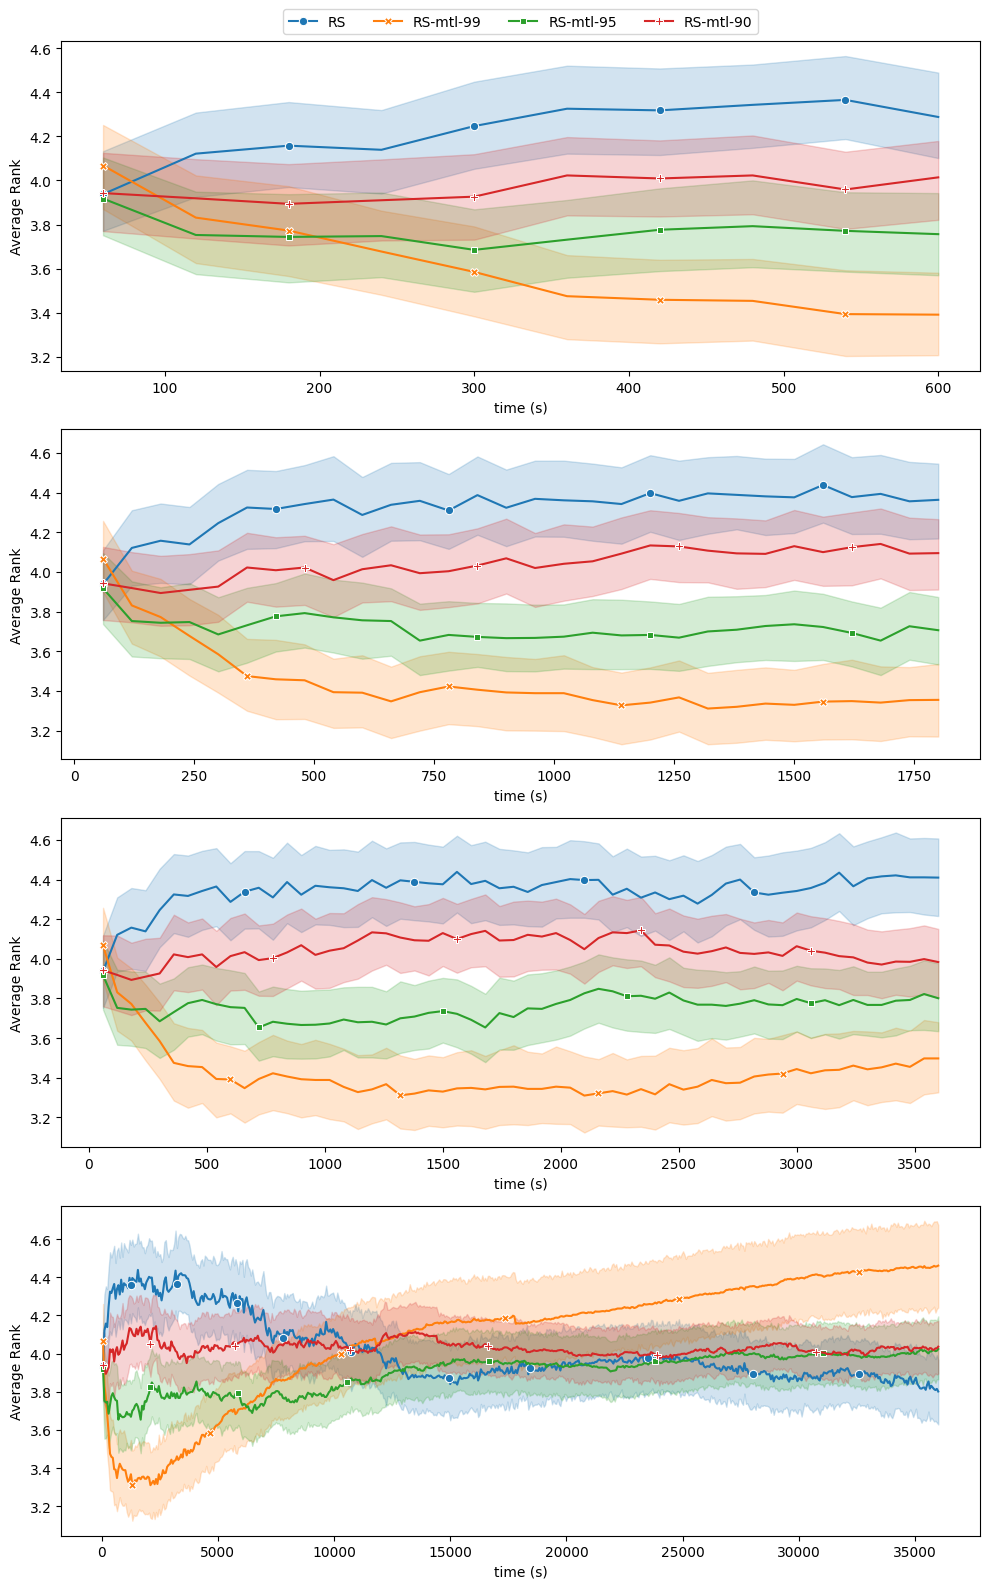

In [8]:
mult_rank_plot(exp_1, ["RS", "RS-mtl-99", "RS-mtl-95", "RS-mtl-90"], [600, 1800, 3600, 360000])

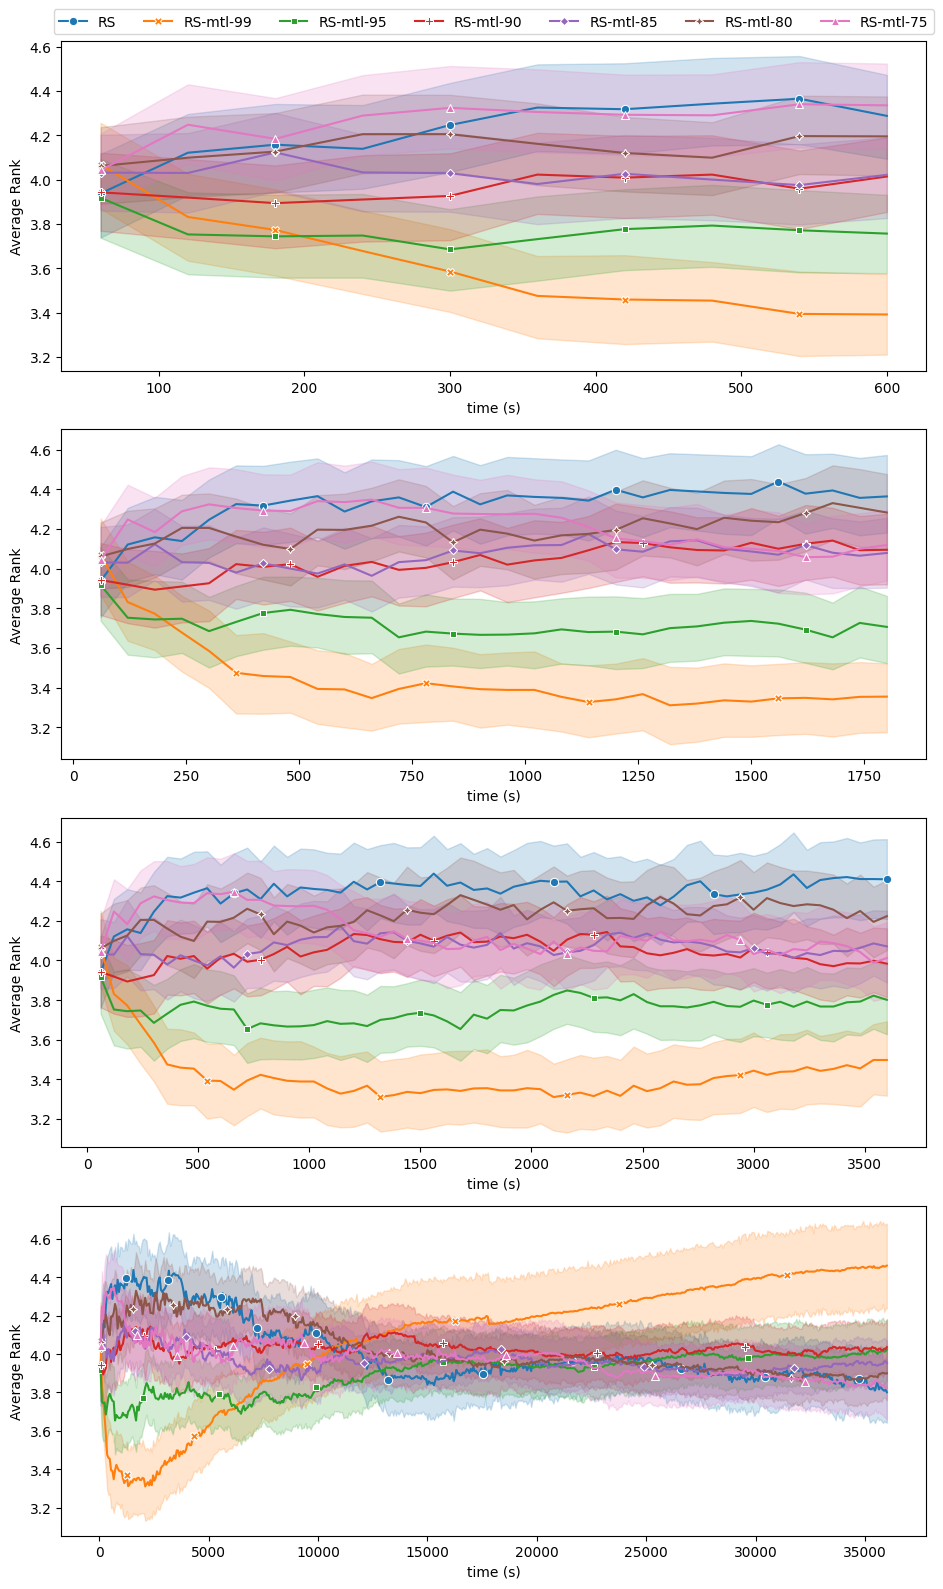

In [9]:
mult_rank_plot(exp_1, ["RS", "RS-mtl-99", "RS-mtl-95", "RS-mtl-90", "RS-mtl-85", "RS-mtl-80", "RS-mtl-75"], [600, 1800, 3600, 360000])

### Proposed vs Literature

In [10]:
rs_landmarking = pd.read_csv("experiments-analysis/RS-landmarking_over_time_60_36060.csv")
rs_autosklearn_2 = pd.read_csv("experiments-analysis/RS-autosklearn-2_over_time_60_36060.csv")
rs_random = pd.read_csv("experiments-analysis/RS-random_over_time_60_36060.csv")

In [11]:
exp_2 = pd.concat([
  rs,
  rs_mtl_99,
  rs_mtl_95,
  rs_landmarking,
  rs_autosklearn_2,
  rs_random,
])

exp_2["rank"] = exp_2.groupby(["seed", "dataset", "time"])["performance"].rank(ascending=False)

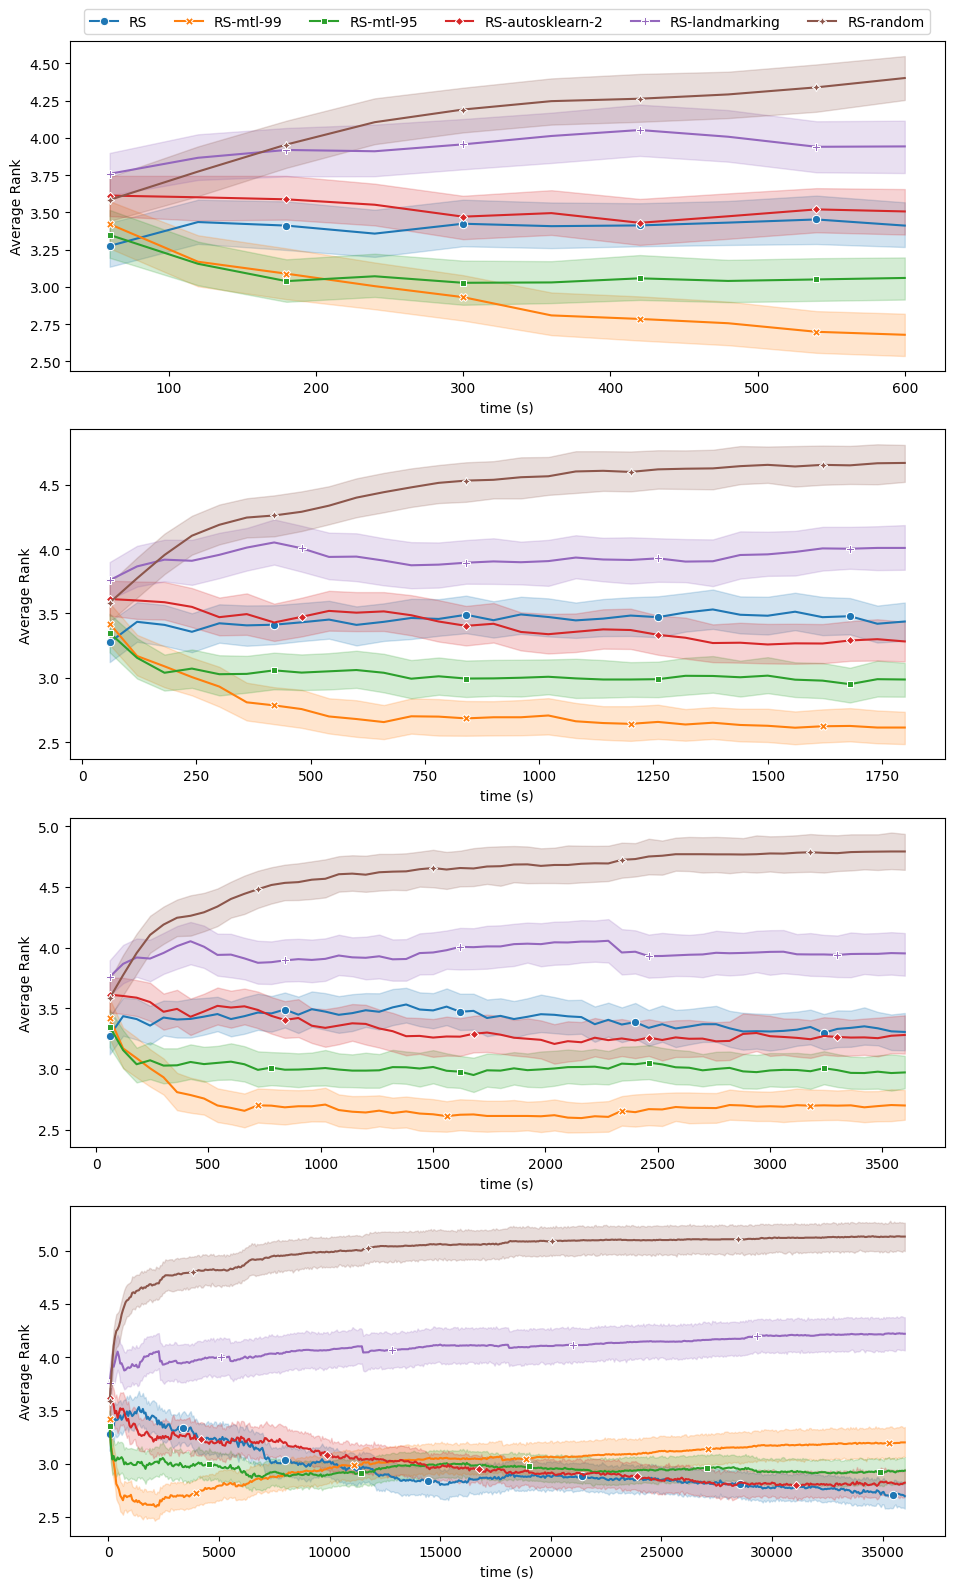

In [12]:
mult_rank_plot(exp_2, ["RS", "RS-mtl-99", "RS-mtl-95", "RS-autosklearn-2", "RS-landmarking", "RS-random"], [600, 1800, 3600, 360000])

## Efficiency Analysis

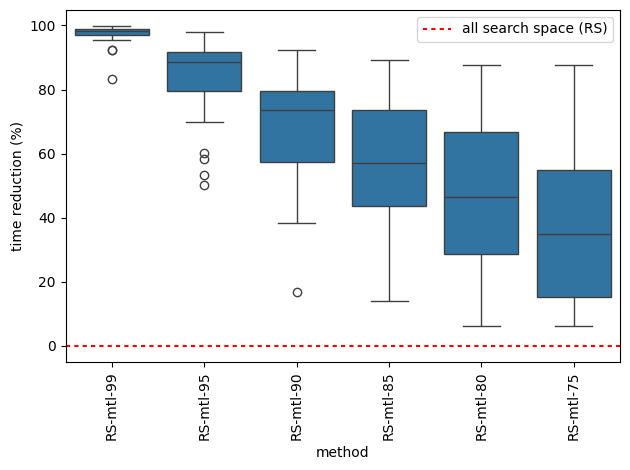

In [48]:
methods = {
    "RS-mtl-99": pd.read_csv("experiments/meta_automl_omega_0.99.csv"),
    "RS-mtl-95": pd.read_csv("experiments/meta_automl_omega_0.95.csv"),
    "RS-mtl-90": pd.read_csv("experiments/meta_automl_omega_0.9.csv"),
    "RS-mtl-85": pd.read_csv("experiments/meta_automl_omega_0.85.csv"),
    "RS-mtl-80": pd.read_csv("experiments/meta_automl_omega_0.8.csv"),
    "RS-mtl-75": pd.read_csv("experiments/meta_automl_omega_0.75.csv"),

    "RS": pd.read_csv("experiments/rs_automl.csv")
}

r = []
for m_name, m in methods.items():
  r.append(m.groupby(["dataset"])["cumulative_sum_cv_duration_mtf"].max().to_frame(m_name))

compare_with = "RS"
aux_ = pd.concat(r, axis=1)
for m_name in aux_.columns.to_list():
  aux_[m_name] = round(100*(1 - (aux_[m_name] / aux_[compare_with])), 2)

aux_ = aux_.melt(var_name="method", value_name="time reduction (%)").sort_values(by="method", ascending=False)
order = round(aux_.groupby(["method"])["time reduction (%)"].median().sort_values(ascending=False))

g = sns.boxplot(data=aux_.query("method != 'RS'"), x="method", y="time reduction (%)", order=order.index[:-1])
g.axhline(order.iloc[-1], color="red", dashes=(2, 2), label="all search space (RS)")

plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("experiments-analysis/boxplot_time_reduction_mtl.pdf")
plt.show()

In [49]:
order

,time reduction (%)
method,
RS-mtl-99,98.0
RS-mtl-95,89.0
RS-mtl-90,74.0
RS-mtl-85,57.0
RS-mtl-80,47.0
RS-mtl-75,35.0
RS,0.0


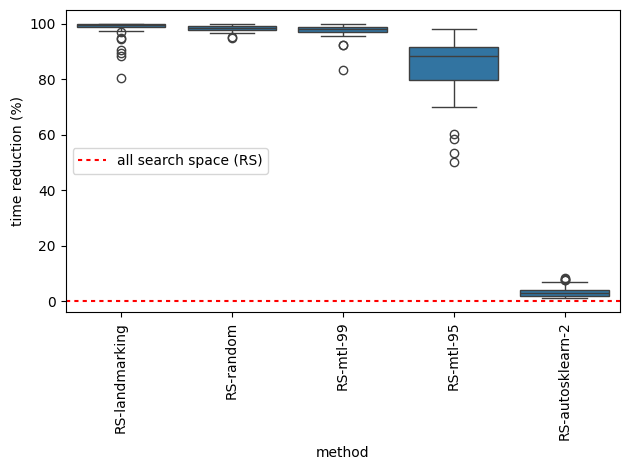

In [47]:
methods = {
    "RS-mtl-99": pd.read_csv("experiments/meta_automl_omega_0.99.csv"),
    "RS-mtl-95": pd.read_csv("experiments/meta_automl_omega_0.95.csv"),
    # "RS-mtl-90": pd.read_csv("experiments/meta_automl_omega_0.9.csv"),
    "RS-landmarking": pd.read_csv("experiments/landmarking_meta_automl.csv"),
    "RS-autosklearn-2": pd.read_csv("experiments/autosklearn_2_meta_automl.csv"),
    "RS-random": pd.read_csv("experiments/random_meta_automl.csv"),
    "RS": pd.read_csv("experiments/rs_automl.csv")
}

r = []
for m_name, m in methods.items():
  r.append(m.groupby(["dataset"])["cumulative_sum_cv_duration_mtf"].max().to_frame(m_name))

compare_with = "RS"
aux_ = pd.concat(r, axis=1)
for m_name in aux_.columns.to_list():
  aux_[m_name] = round(100*(1 - (aux_[m_name] / aux_[compare_with])), 2)

aux_ = aux_.melt(var_name="method", value_name="time reduction (%)").sort_values(by="method", ascending=False)
order = round(aux_.groupby(["method"])["time reduction (%)"].median().sort_values(ascending=False))

g = sns.boxplot(data=aux_.query("method != 'RS'"), x="method", y="time reduction (%)", order=order.index[:-1])
g.axhline(order.iloc[-1], color="red", dashes=(2, 2), label="all search space (RS)")

plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("experiments-analysis/boxplot_time_reduction.pdf")
plt.show()


In [14]:
order

,time reduction (%)
method,
RS-landmarking,99.0
RS-random,98.0
RS-mtl-99,98.0
RS-mtl-95,89.0
RS-autosklearn-2,3.0
RS,0.0


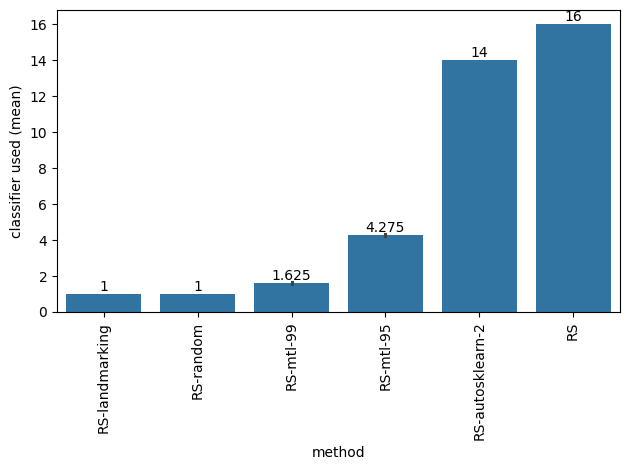

In [15]:
r = []
for m_name, m in methods.items():
  r.append(m.groupby(["seed", "dataset"])["classifier"].nunique().to_frame(m_name))

aux_ = pd.concat(r, axis=1)
aux_ = aux_.melt(var_name="method", value_name="classifier used (mean)").sort_values(by="method", ascending=False)
order = round(aux_.groupby(["method"])["classifier used (mean)"].median().sort_values(ascending=True))

g = sns.barplot(data=aux_, x="method", y="classifier used (mean)", order=order.index)
# g.axhline(order.iloc[-1], color="red", dashes=(2, 2), label="all preprocessor (RS)")

for i in g.containers:
  g.bar_label(i,)

plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("experiments-analysis/barplot_classifier_used_mean.pdf")
plt.show()

In [16]:
order

,classifier used (mean)
method,
RS-landmarking,1.0
RS-random,1.0
RS-mtl-99,2.0
RS-mtl-95,4.0
RS-autosklearn-2,14.0
RS,16.0


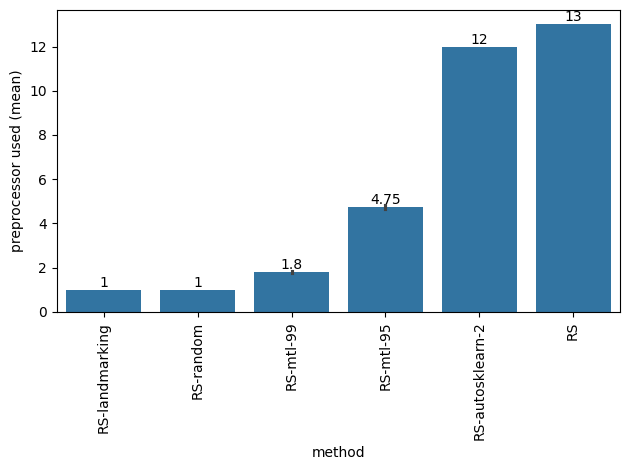

In [45]:
r = []
for m_name, m in methods.items():
  r.append(m.groupby(["seed", "dataset"])["preprocessor"].nunique().to_frame(m_name))

aux_ = pd.concat(r, axis=1)
aux_ = aux_.melt(var_name="method", value_name="preprocessor used (mean)").sort_values(by="method", ascending=False)
order = round(aux_.groupby(["method"])["preprocessor used (mean)"].median().sort_values(ascending=True))

g = sns.barplot(data=aux_, x="method", y="preprocessor used (mean)", order=order.index)
# g.axhline(order.iloc[-1], color="red", dashes=(2, 2), label="all preprocessor (RS)")

for i in g.containers:
    g.bar_label(i,)

# plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("experiments-analysis/barplot_preprocessor_used_mean.pdf")
plt.show()

In [18]:
order

,preprocessor used (mean)
method,
RS-landmarking,1.0
RS-random,1.0
RS-mtl-99,2.0
RS-mtl-95,5.0
RS-autosklearn-2,12.0
RS,13.0


## Statistical Test

In [19]:
def statistical_test_scv(df, time):
  aux_ = df\
    .query(f"time == {time}")\
    .pivot(index=["dataset", "seed"],columns="method", values="performance")

  aux_.to_csv(PATH + f"meta-automl-all-{time}.csv", index=False)

  return aux_

In [20]:
mask = exp_1["method"].isin(["RS", "RS-mtl-99", "RS-mtl-95", "RS-mtl-90"])
exp_1_ = exp_1[mask]
statistical_test_scv(exp_1_, 600)
statistical_test_scv(exp_1_, 1800)
statistical_test_scv(exp_1_, 3600)
statistical_test_scv(exp_1_, 36000)

method                   RS  RS-mtl-90  RS-mtl-95  RS-mtl-99
dataset      seed                                           
dataset_1044 0     0.614997   0.699956   0.699956   0.664783
             1     0.699956   0.699956   0.699956   0.664783
             2     0.668046   0.699956   0.699956   0.664783
             3     0.690307   0.699956   0.699956   0.664783
             4     0.699956   0.699956   0.699956   0.664783
...                     ...        ...        ...        ...
dataset_951  5     0.992156   0.993354   1.000000   1.000000
             6     1.000000   1.000000   0.992156   0.993354
             7     1.000000   1.000000   0.992156   1.000000
             8     1.000000   1.000000   0.992156   1.000000
             9     1.000000   0.992156   0.992156   0.993354

[400 rows x 4 columns]

In [21]:
exp_2_ = exp_2
statistical_test_scv(exp_2_, 600)
statistical_test_scv(exp_2_, 1800)
statistical_test_scv(exp_2_, 3600)
statistical_test_scv(exp_2_, 36000)

method                   RS  RS-autosklearn-2  RS-landmarking  RS-mtl-95  \
dataset      seed                                                          
dataset_1044 0     0.614997          0.699956        0.621637   0.699956   
             1     0.699956          0.699758        0.621637   0.699956   
             2     0.668046          0.699758        0.621637   0.699956   
             3     0.690307          0.699956        0.621637   0.699956   
             4     0.699956          0.699956        0.621637   0.699956   
...                     ...               ...             ...        ...   
dataset_951  5     0.992156          1.000000        1.000000   1.000000   
             6     1.000000          0.992156        1.000000   0.992156   
             7     1.000000          1.000000        1.000000   0.992156   
             8     1.000000          1.000000        1.000000   0.992156   
             9     1.000000          0.992156        1.000000   0.992156   

method             RS-mtl-99  RS-random  
dataset      seed                        
dataset_1044 0      0.664783   0.457199  
             1      0.664783   0.699956  
             2      0.664783   0.510654  
             3      0.664783   0.459404  
             4      0.664783   0.470350  
...                      ...        ...  
dataset_951  5      1.000000   0.992156  
             6      0.993354   1.000000  
             7      1.000000   0.992156  
             8      1.000000   1.000000  
             9      0.993354   1.000000  

[400 rows x 6 columns]

## Performance Table

In [22]:
!pip install openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.3 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=384955509e3d013ddc5b5ddff04f3a2d439d6cda9c08579a86ca24a0f8f341f6
  Stored in directory: /root/.cache/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff


In [23]:
import openml
all_datasets = pd.read_csv("../pipeline_experiment_result.csv")["dataset"].unique().tolist()
all_datasets_ = [int(d.split("_")[1]) for d in all_datasets]
all_datasets_ = [(d, openml.datasets.get_dataset(d).name.lower(), ) for d in all_datasets_]
all_datasets_ = [(i, j, j[:8]+"...") if len(j) >= 8 else (i, j, j) for i, j in all_datasets_]
all_datasets_ = pd.DataFrame(all_datasets_).rename(columns={0: "OpenML ID", 1:"Full-Name", 2:"Short-Name"})
all_datasets_.to_csv(PATH + "datasets_id_name.csv", index=False)

<ipython-input-23-387e0e0081d5>:2: DtypeWarning: Columns (19,20,60,200,201) have mixed types. Specify dtype option on import or set low_memory=False.
  all_datasets = pd.read_csv("../pipeline_experiment_result.csv")["dataset"].unique().tolist()


In [24]:
def my_agg(x):
  return "$ {0:.4f} \pm {1:.2f} $".format(x.mean(), x.std())

aux_600 = exp_2\
  .query(f"time == {600}")\
  .pivot(index=["dataset", "seed"],columns="method", values="performance")\
  .groupby(["dataset"]).agg(my_agg)\
  .round(4)\
  .reset_index()

aux_600["OpenML ID"] = [int(i.split("_")[1]) for i in aux_600["dataset"]]
aux_600 = aux_600.sort_values(by="OpenML ID", ascending=True).drop(columns=["dataset"])
aux_600 = aux_600.merge(all_datasets_, on="OpenML ID")
aux_600 = aux_600[["OpenML ID","Short-Name", "RS-mtl-99", "RS-mtl-95", "RS-landmarking", "RS-autosklearn-2", "RS"]]

In [25]:
aux_600

,OpenML ID,Short-Name,RS-mtl-99,RS-mtl-95,RS-landmarking,RS-autosklearn-2,RS
0,11,balance-...,$ 0.8962 \pm 0.00 $,$ 0.9630 \pm 0.01 $,$ 0.8416 \pm 0.00 $,$ 0.8608 \pm 0.06 $,$ 0.9167 \pm 0.07 $
1,23,cmc,$ 0.5469 \pm 0.00 $,$ 0.5043 \pm 0.03 $,$ 0.5671 \pm 0.00 $,$ 0.4634 \pm 0.03 $,$ 0.4740 \pm 0.06 $
2,28,optdigit...,$ 0.9818 \pm 0.00 $,$ 0.9784 \pm 0.00 $,$ 0.9836 \pm 0.00 $,$ 0.9395 \pm 0.05 $,$ 0.9766 \pm 0.01 $
3,30,page-blo...,$ 0.9664 \pm 0.01 $,$ 0.8740 \pm 0.31 $,$ 0.9075 \pm 0.00 $,$ 0.9666 \pm 0.01 $,$ 0.9606 \pm 0.01 $
4,155,pokerhan...,$ 0.0000 \pm 0.00 $,$ 0.0433 \pm 0.14 $,$ 0.0000 \pm 0.00 $,$ 0.1591 \pm 0.26 $,$ 0.1388 \pm 0.32 $
5,181,yeast,$ 0.5532 \pm 0.00 $,$ 0.5428 \pm 0.01 $,$ 0.5493 \pm 0.00 $,$ 0.5437 \pm 0.03 $,$ 0.5458 \pm 0.03 $
6,307,vowel,$ 0.9478 \pm 0.00 $,$ 0.9077 \pm 0.05 $,$ 0.6338 \pm 0.00 $,$ 0.9157 \pm 0.04 $,$ 0.8968 \pm 0.10 $
7,725,bank8fm,$ 0.9413 \pm 0.00 $,$ 0.9387 \pm 0.00 $,$ 0.9340 \pm 0.00 $,$ 0.9305 \pm 0.01 $,$ 0.9326 \pm 0.01 $
8,761,cpu_act,$ 0.9354 \pm 0.00 $,$ 0.8820 \pm 0.11 $,$ 0.1870 \pm 0.39 $,$ 0.9057 \pm 0.02 $,$ 0.9185 \pm 0.03 $
9,770,strikes,$ 0.9758 \pm 0.01 $,$ 0.9834 \pm 0.01 $,$ 0.8514 \pm 0.00 $,$ 0.9841 \pm 0.02 $,$ 0.9751 \pm 0.06 $


In [26]:
aux_600.to_csv(PATH + "performance-table-at-600s.csv")

In [27]:

aux_3600 = exp_2\
  .query(f"time == {3600}")\
  .pivot(index=["dataset", "seed"],columns="method", values="performance")\
  .groupby(["dataset"]).agg(my_agg)\
  .round(4)\
  .reset_index()

aux_3600["OpenML ID"] = [int(i.split("_")[1]) for i in aux_3600["dataset"]]
aux_3600 = aux_3600.sort_values(by="OpenML ID", ascending=True).drop(columns=["dataset"])
aux_3600 = aux_3600.merge(all_datasets_, on="OpenML ID")
aux_3600 = aux_3600[["OpenML ID","Short-Name", "RS-mtl-99", "RS-mtl-95", "RS-landmarking", "RS-autosklearn-2", "RS"]]

In [28]:
aux_3600

,OpenML ID,Short-Name,RS-mtl-99,RS-mtl-95,RS-landmarking,RS-autosklearn-2,RS
0,11,balance-...,$ 0.8962 \pm 0.00 $,$ 0.9754 \pm 0.00 $,$ 0.8416 \pm 0.00 $,$ 0.9289 \pm 0.05 $,$ 0.9391 \pm 0.05 $
1,23,cmc,$ 0.5469 \pm 0.00 $,$ 0.4993 \pm 0.00 $,$ 0.5671 \pm 0.00 $,$ 0.4890 \pm 0.03 $,$ 0.4986 \pm 0.02 $
2,28,optdigit...,$ 0.9801 \pm 0.00 $,$ 0.9829 \pm 0.00 $,$ 0.9836 \pm 0.00 $,$ 0.9664 \pm 0.03 $,$ 0.9813 \pm 0.01 $
3,30,page-blo...,$ 0.9784 \pm 0.00 $,$ 0.9728 \pm 0.00 $,$ 0.9075 \pm 0.00 $,$ 0.9726 \pm 0.00 $,$ 0.9667 \pm 0.01 $
4,155,pokerhan...,$ 0.0000 \pm 0.00 $,$ 0.3764 \pm 0.41 $,$ 0.0000 \pm 0.00 $,$ 0.4752 \pm 0.26 $,$ 0.3694 \pm 0.36 $
5,181,yeast,$ 0.5532 \pm 0.00 $,$ 0.5428 \pm 0.00 $,$ 0.5493 \pm 0.00 $,$ 0.5731 \pm 0.02 $,$ 0.5628 \pm 0.02 $
6,307,vowel,$ 0.9478 \pm 0.00 $,$ 0.9556 \pm 0.00 $,$ 0.6338 \pm 0.00 $,$ 0.9512 \pm 0.00 $,$ 0.9438 \pm 0.01 $
7,725,bank8fm,$ 0.9413 \pm 0.00 $,$ 0.9394 \pm 0.00 $,$ 0.9340 \pm 0.00 $,$ 0.9380 \pm 0.00 $,$ 0.9374 \pm 0.00 $
8,761,cpu_act,$ 0.9354 \pm 0.00 $,$ 0.9348 \pm 0.00 $,$ 0.9376 \pm 0.00 $,$ 0.9221 \pm 0.02 $,$ 0.9295 \pm 0.01 $
9,770,strikes,$ 0.9758 \pm 0.01 $,$ 0.9885 \pm 0.01 $,$ 0.8514 \pm 0.00 $,$ 0.9936 \pm 0.01 $,$ 0.9681 \pm 0.06 $


In [29]:
aux_3600.to_csv(PATH + "performance-table-at-3600s.csv")

In [30]:
exp_2.query("time == 3600").groupby(["method"])["rank"].agg(["mean", "std"])

,mean,std
method,,
RS,3.30500,1.478577
RS-autosklearn-2,3.28000,1.602504
RS-landmarking,3.95250,1.782045
RS-mtl-95,2.97125,1.408815
RS-mtl-99,2.69875,1.287543
RS-random,4.79250,1.498351


In [31]:
exp_2.query("time == 600").groupby(["method"])["rank"].agg(["mean", "std"])

,mean,std
method,,
RS,3.41125,1.512769
RS-autosklearn-2,3.50625,1.552534
RS-landmarking,3.94250,1.805851
RS-mtl-95,3.06000,1.496077
RS-mtl-99,2.67875,1.435296
RS-random,4.40125,1.555046


In [32]:
DATASET_PATHS = [
    "../dataset-analysis/datasets_meta_data_train.csv",
    "../dataset-analysis/datasets_meta_data_test.csv"
]
for df_path in DATASET_PATHS:
  df1 = pd.read_csv(df_path)
  df2 = pd.read_csv(PATH + "datasets_id_name.csv")

  r = df1.merge(df2, on="OpenML ID")
  assert r.shape[0] == df1.shape[0]

  new_name = df_path.split(".")[0] + "_with_name.csv"
  r.to_csv(new_name, index=False)

## Train vs Validation vs Test

In [33]:
aux = methods["RS"].copy()
aux

,dataset,preprocessor,classifier,f1_weighted_train,f1_weighted_val,f1_weighted_test,cv_median_f1_weighted,sum_cv_duration,cumulative_sum_cv_duration,cumulative_sum_cv_duration_mtf,seed
0,dataset_40985,no_preprocessing,decision_tree,0.012617,0.012425,0.011821,0.012472,13.344439,13.344439,13.344439,0
1,dataset_40985,fast_ica,gaussian_nb,0.040278,0.040292,0.036541,0.040415,16.068777,29.413216,29.413216,0
2,dataset_40985,pca,random_forest,0.000000,0.000000,0.000000,0.000000,6001.673220,6031.086436,6031.086436,0
3,dataset_40985,select_percentile_classification,qda,0.019640,0.020119,0.020094,0.020059,19.582187,6050.668623,6050.668623,0
4,dataset_40985,fast_ica,sgd,0.007196,0.007179,0.007206,0.007181,24.871367,6075.539989,6075.539989,0
...,...,...,...,...,...,...,...,...,...,...,...
198745,dataset_816,extra_trees_preproc_for_classification,gaussian_nb,0.829082,0.827630,0.830544,0.829938,17.126281,28263.292243,28263.292243,9
198746,dataset_816,polynomial,qda,0.000000,0.000000,0.000000,0.000000,10.693412,28273.985655,28273.985655,9
198747,dataset_816,extra_trees_preproc_for_classification,passive_aggressive,0.824364,0.819479,0.824705,0.821790,16.938757,28290.924412,28290.924412,9
198748,dataset_816,no_preprocessing,gradient_boosting,0.938687,0.939837,0.811524,0.939788,27.427130,28318.351542,28318.351542,9


In [34]:
def best_pipe_test_performance(method, dataset, time, seed):
  aux = method.query(f"seed == {seed} and dataset == '{dataset}' and cumulative_sum_cv_duration_mtf <= {time}")
  if len(aux) != 0:
    return aux.sort_values(by="cv_median_f1_weighted", ascending=False).head(1)["f1_weighted_test"].values[0]
  return 0.0

train_val_diff = (methods["RS"]["f1_weighted_train"] - methods["RS"]["f1_weighted_val"]).abs()
test_val_diff = (methods["RS"]["f1_weighted_test"] - methods["RS"]["f1_weighted_val"]).abs()
aux["train_val_diff"] = train_val_diff
aux["test_val_diff"] = test_val_diff

id = aux.query("cumulative_sum_cv_duration_mtf <= 600").groupby(["seed", "dataset"])["f1_weighted_val"].idxmax()
aux.loc[id]

,dataset,preprocessor,classifier,f1_weighted_train,f1_weighted_val,f1_weighted_test,cv_median_f1_weighted,sum_cv_duration,cumulative_sum_cv_duration,cumulative_sum_cv_duration_mtf,seed,train_val_diff,test_val_diff
7007,dataset_1044,pca,k_nearest_neighbors,0.876029,0.876935,0.614997,0.877481,13.633437,564.527227,564.527227,0,0.000906,0.261938
10505,dataset_1046,pca,k_nearest_neighbors,0.974644,0.974338,0.918123,0.974735,12.805098,414.457141,414.457141,0,0.000306,0.056215
2509,dataset_1053,pca,k_nearest_neighbors,0.904744,0.906173,0.728821,0.906670,12.470769,356.497005,356.497005,0,0.001429,0.177352
6031,dataset_11,polynomial,liblinear_svc,1.000000,1.000000,1.000000,1.000000,11.478635,451.708618,451.708618,0,0.000000,0.000000
17875,dataset_1166,no_preprocessing,decision_tree,0.919325,0.931483,0.924404,0.929792,49.256887,49.256887,49.256887,0,0.012158,0.007079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192864,dataset_901,no_preprocessing,gradient_boosting,0.975325,0.974493,0.922289,0.974816,138.982826,152.504227,152.504227,9,0.000832,0.052204
180413,dataset_934,no_preprocessing,mlp,0.978255,0.977149,0.945227,0.977282,14.750431,598.295093,598.295093,9,0.001106,0.031922
182380,dataset_937,extra_trees_preproc_for_classification,adaboost,0.940489,0.921218,0.804800,0.933701,15.858848,87.454695,87.454695,9,0.019271,0.116418
187381,dataset_940,liblinear_svc_preprocessor,adaboost,0.997194,1.000000,1.000000,1.000000,14.362955,400.392103,400.392103,9,0.002806,0.000000


In [35]:
import numpy as np

def get_diff_train_val_test(method, dataset, time, seed):
  aux = method.query(f"seed == {seed} and dataset == '{dataset}' and cumulative_sum_cv_duration_mtf <= {time}")
  if len(aux) != 0:
    aux = aux.sort_values(by="cv_median_f1_weighted", ascending=False).head(1)
    train = aux["f1_weighted_train"].values[0]
    val = aux["f1_weighted_val"].values[0]
    test = aux["f1_weighted_test"].values[0]
    return np.abs(train - val), np.abs(train - test), np.abs(val - test)
  return 0.0, 0.0, 0.0

r = {
    "train_val_diff": [],
    "train_test_diff": [],
    "val_test_diff": [],
    "method": [],
    "dataset": [],
    "time": [],
    "seed": []
}

for method_name, method in {"RS": methods["RS"], "RS-mtl-95": methods["RS-mtl-95"]}.items():
  for time in range(0, 36000, 600):
    for seed in aux["seed"].unique():
      for dataset in aux["dataset"].unique():
        train_val_diff, train_test_diff, val_test_diff = get_diff_train_val_test(method, dataset, time, seed)
        r["train_val_diff"].append(train_val_diff)
        r["train_test_diff"].append(train_test_diff)
        r["val_test_diff"].append(val_test_diff)
        r["method"].append(method_name)
        r["dataset"].append(dataset)
        r["time"].append(time)
        r["seed"].append(seed)

r = pd.DataFrame(r)

In [36]:
r

,train_val_diff,train_test_diff,val_test_diff,method,dataset,time,seed
0,0.000000,0.000000,0.000000,RS,dataset_40985,0,0
1,0.000000,0.000000,0.000000,RS,dataset_1501,0,0
2,0.000000,0.000000,0.000000,RS,dataset_1528,0,0
3,0.000000,0.000000,0.000000,RS,dataset_934,0,0
4,0.000000,0.000000,0.000000,RS,dataset_1553,0,0
...,...,...,...,...,...,...,...
47995,0.000819,0.011539,0.012359,RS-mtl-95,dataset_28,35400,9
47996,0.000900,0.048666,0.047766,RS-mtl-95,dataset_1166,35400,9
47997,0.000214,0.015213,0.015427,RS-mtl-95,dataset_823,35400,9
47998,0.014649,0.115327,0.129976,RS-mtl-95,dataset_1515,35400,9


<Axes: xlabel='time', ylabel='train_test_diff'>

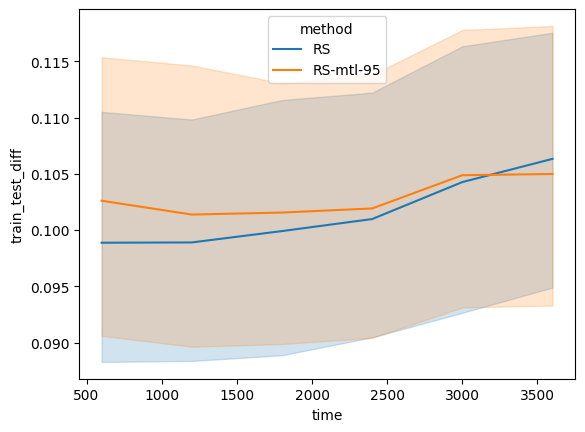

In [37]:
sns.lineplot(data=r.query("time > 60 and time <= 3600"), x="time", y="train_test_diff", hue="method")

<Axes: xlabel='time', ylabel='train_val_diff'>

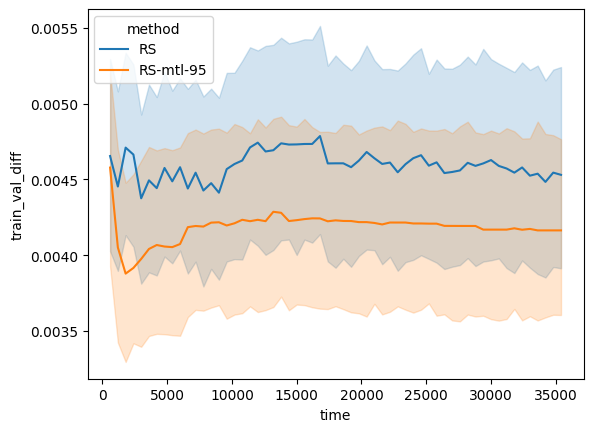

In [38]:
sns.lineplot(data=r.query("time > 60"), x="time", y="train_val_diff", hue="method")

<Axes: xlabel='time', ylabel='val_test_diff'>

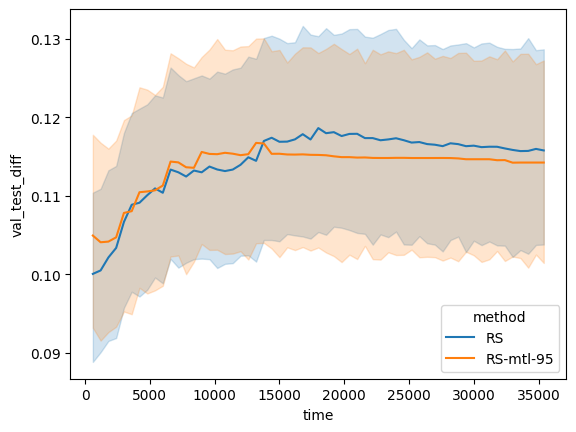

In [39]:
sns.lineplot(data=r.query("time > 60"), x="time", y="val_test_diff", hue="method")

## Pipelines

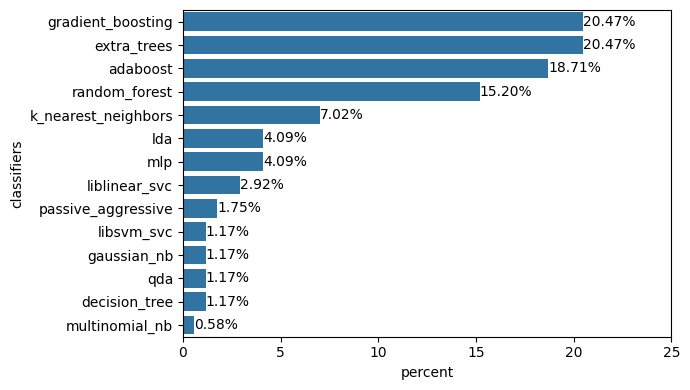

In [40]:
best_90 = pd.read_csv("experiments/meta_automl_omega_0.95.csv")
cls = best_90.groupby(["dataset"])["classifier"].unique()

cls_list = []
for i in cls:
  cls_list = cls_list + i.tolist()

w = "classifiers"
cls = pd.DataFrame({w:cls_list})
order = cls[w].value_counts().index

plt.figure(figsize=(7,4))
g = sns.countplot(cls, y=w, stat="percent", order=order)

for i in g.containers:
  g.bar_label(i, fmt='%.2f%%')

g.set_xlim(0, 25)
plt.tight_layout()
plt.savefig("experiments-analysis/perc_classifiers.pdf")
plt.show()

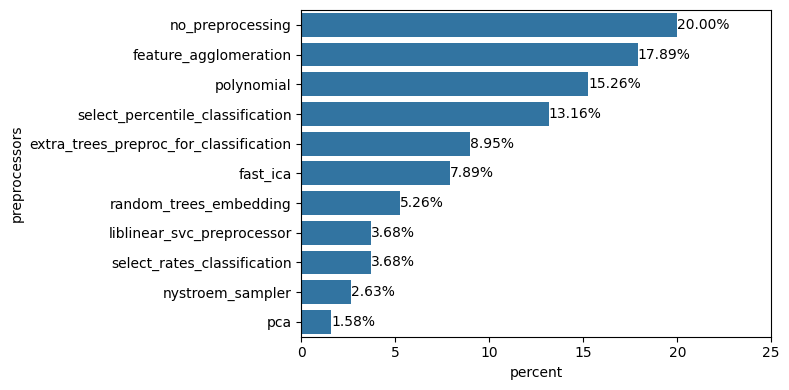

In [41]:
best_90 = pd.read_csv("experiments/meta_automl_omega_0.95.csv")
cls = best_90.groupby(["dataset"])["preprocessor"].unique()

cls_list = []
for i in cls:
  cls_list = cls_list + i.tolist()

w = "preprocessors"
cls = pd.DataFrame({w:cls_list})
order = cls[w].value_counts().index

plt.figure(figsize=(8,4))
g = sns.countplot(cls, y=w, stat="percent", order=order)

for i in g.containers:
  g.bar_label(i, fmt='%.2f%%')

g.set_xlim(0, 25)
plt.tight_layout()
plt.savefig("experiments-analysis/perc_preprocessors.pdf")
plt.show()

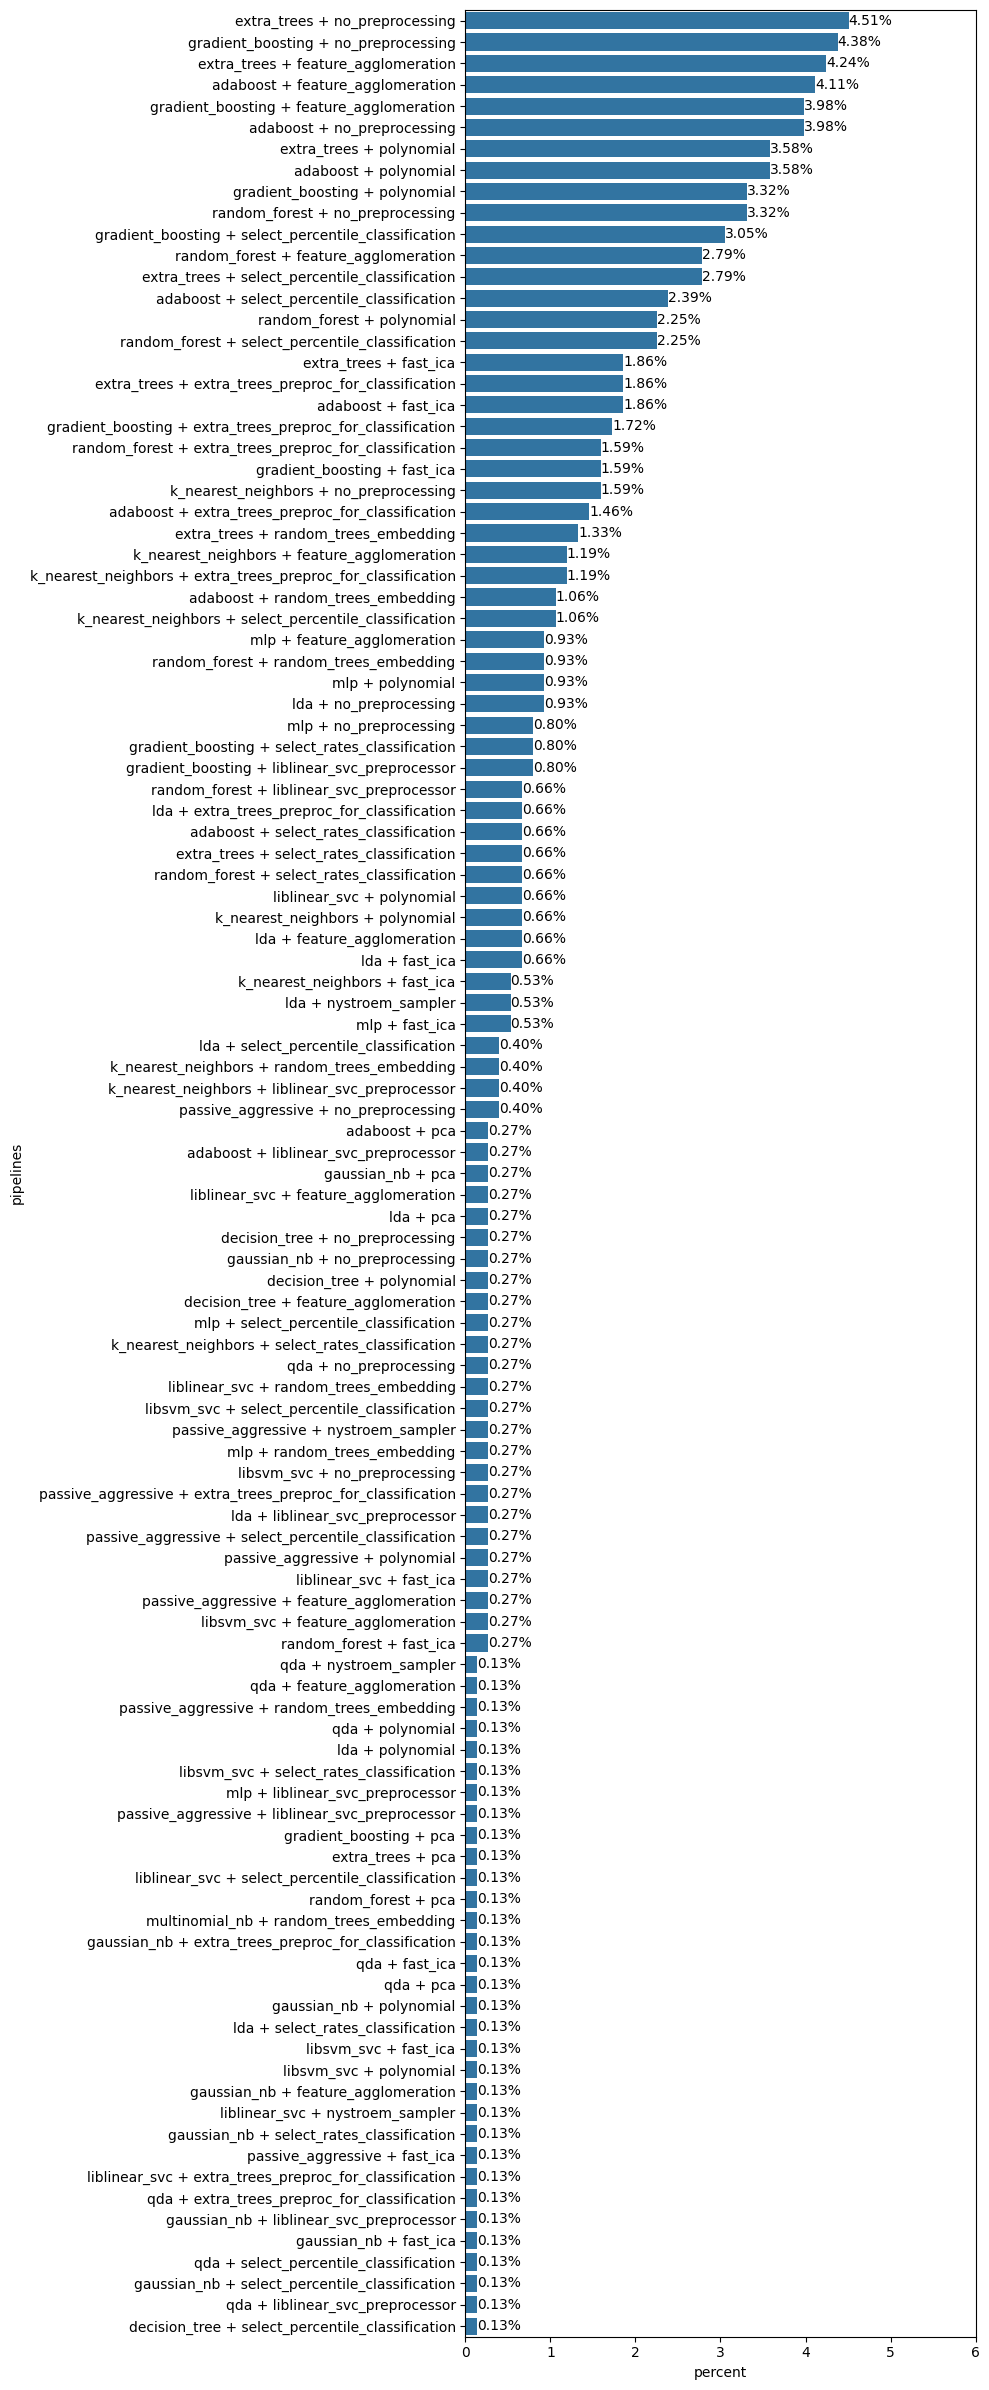

In [42]:
best_90 = pd.read_csv("experiments/meta_automl_omega_0.95.csv")
best_90["pipelines"] = best_90["classifier"] + " + " + best_90["preprocessor"]
cls = best_90.groupby(["dataset"])["pipelines"].unique()

cls_list = []
for i in cls:
  cls_list = cls_list + i.tolist()

w = "pipelines"
cls = pd.DataFrame({w:cls_list})
order = cls[w].value_counts().index

plt.figure(figsize=(10,24))
g = sns.countplot(cls, y=w, stat="percent", order=order)

for i in g.containers:
  g.bar_label(i, fmt='%.2f%%')

g.set_xlim(0, 6)
plt.tight_layout()
plt.savefig("experiments-analysis/perc_pipelines_all.pdf")
plt.show()

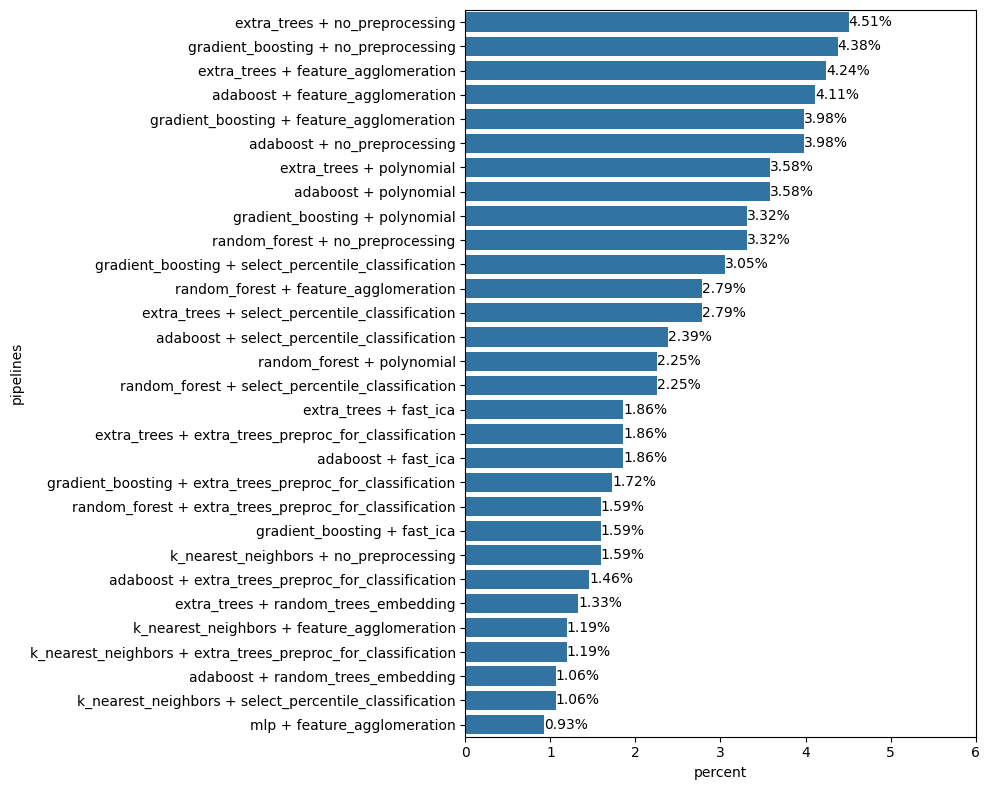

In [43]:
best_90 = pd.read_csv("experiments/meta_automl_omega_0.95.csv")
best_90["pipelines"] = best_90["classifier"] + " + " + best_90["preprocessor"]
cls = best_90.groupby(["dataset"])["pipelines"].unique()

cls_list = []
for i in cls:
  cls_list = cls_list + i.tolist()

w = "pipelines"
cls = pd.DataFrame({w:cls_list})
order = cls[w].value_counts().index[:30]

plt.figure(figsize=(10,8))
g = sns.countplot(cls, y=w, stat="percent", order=order)

for i in g.containers:
  g.bar_label(i, fmt='%.2f%%')

g.set_xlim(0, 6)
plt.tight_layout()
plt.savefig("experiments-analysis/perc_pipelines.pdf")
plt.show() # 60%